In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SoccerNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 66.1 MB/s eta 0:00:00


In [ ]:
# import SoccerNet
# from SoccerNet.Downloader import SoccerNetDownloader
# mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="/content/drive/MyDrive/deformable-detr-soccer-analysis/data")

# mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train", "test", "challenge"])

# mySoccerNetDownloader.downloadDataTask(task="tracking-2023", split=["train", "test", "challenge"])

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected person with confidence 0.832 at location [910.53, 853.44, 973.87, 1021.43]
Detected person with confidence 0.779 at location [987.25, 460.91, 1017.93, 565.61]
Detected person with confidence 0.777 at location [636.27, 394.92, 671.54, 488.17]
Detected person with confidence 0.766 at location [956.96, 552.74, 1004.05, 688.74]
Detected person with confidence 0.76 at location [1422.0, 530.19, 1459.22, 643.39]
Detected person with confidence 0.755 at location [1259.11, 671.83, 1300.89, 805.49]
Detected person with confidence 0.731 at location [801.39, 352.62, 846.9, 431.33]
Detected person with confidence 0.727 at location [915.01, 576.86, 949.74, 696.39]
Detected person with confidence 0.72 at location [1521.48, 478.81, 1568.26, 560.01]
Detected person with confidence 0.683 at location [246.83, 461.17, 273.78, 564.96]
Detected person with confidence 0.667 at location [937.35, 318.64, 964.56, 400.35]
Detected person with confidence 0.66 at location [1093.32, 375.15, 1125.77, 462.49

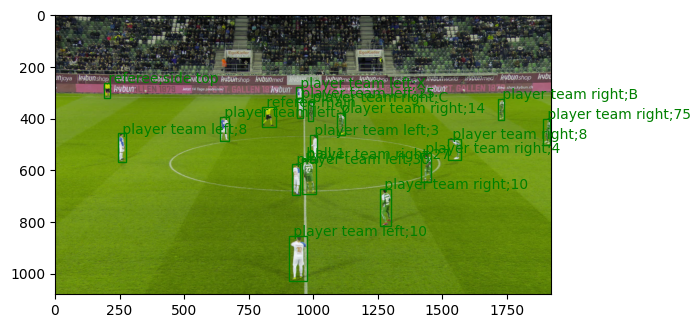

In [13]:
from email.mime import image
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
import torch
from PIL import Image
import requests

gdrive_dir = "/content/drive/deformable-detr-soccer-analysis"
url = "data/tracking/train/SNMOT-060/img1/000002.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open(url)

processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.7
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

# plot the image and the bounding boxes
# also explain what each command does

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.imshow(image)
ax = plt.gca()
# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     rect = patches.Rectangle(
#         (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none"
#     )
#     ax.add_patch(rect)
#     ax.text(box[0], box[1], f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}", color="red")


# plot the same image with ground trur
# gt is located in one directory above the image at gt/gt.txt
# it is a csv with first column as frame number, second number as class id, next two numbers as bounding box coordinates and the next two as width and height, we can ignore rest of the columns
# plot the ground truth bounding boxes in green
# the label is located in gameinfo.ini in one directory above the image
# it is in this format trackletID_1= player team left;10
# so for class id 1, the label is player team left;10

import pandas as pd

gt = pd.read_csv("data/tracking/train/SNMOT-060/gt/gt.txt", header=None)
gt.columns = ["frame", "class", "x", "y", "w", "h"] + [f"extra_{i}" for i in range(4)]

gt = gt[gt["frame"] == 2]

label = open("data/tracking/train/SNMOT-060/gameinfo.ini").read().split("\n")
label = [i for i in label if i.startswith("trackletID")]
label = [i.split("=")[1] for i in label]

for _, row in gt.iterrows():
    rect = patches.Rectangle(
        (row["x"], row["y"]), row["w"], row["h"], linewidth=1, edgecolor="g", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(row["x"], row["y"], f"{label[row['class']-1]}", color="green")
plt.show()


## Dataset

{'1': 'referee', '2': 'referee', '3': 'player_team_right', '4': 'player_team_right', '5': 'player_team_right', '6': 'player_team_right', '7': 'player_team_left', '8': 'player_team_left', '9': 'player_team_left', '10': 'player_team_left', '11': 'player_team_left', '12': 'ball', '13': 'player_team_left', '14': 'player_team_left', '15': 'player_team_right', '16': 'player_team_right', '17': 'player_team_right', '18': 'player_team_left', '19': 'player_team_right', '20': 'player_team_left', '21': 'player_team_right', '22': 'player_team_right', '23': 'player_team_left', '24': 'goalkeeper_team_right', '25': 'goalkeeper_team_left'}


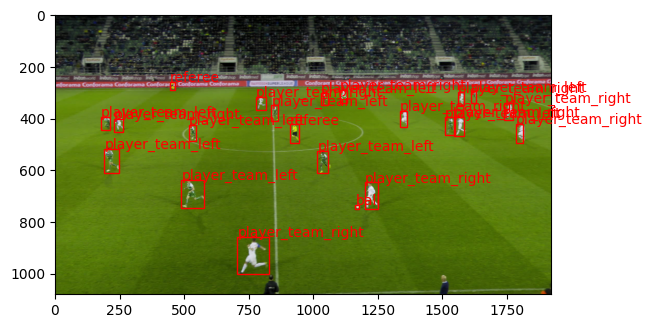

In [37]:

# soccernet data is located in data/tracking/train and data/tracking/test
# in each folder for ex train, there are multiple folders like SNMOT-060, SNMOT-061 etc
# in each of these folders, there are img1 and gt folder
# img1 contains images and gt contains gt.txt file which is a csv file with first column as frame number, second column as class id, next two numbers as bounding box coordinates and the next two as width and height, we can ignore rest of the columns
# create a dataset class to take images from SoccerNet for object detection
# coming to the label, there is a file called gameinfo.ini
# this file contains certain rows starting with trackletID_{class_id}= label;<some number>
# parse this file to get the label for each class id
# there should be 6 classes in total in order - player team left, player team right, ball, referee, goalkeeper team left, goalkeeper team right
# store the images, labels and bounding boxes in the dataset class
# i also want to pass processor to the dataset class so that i can preprocess the images in the dataset class

from matplotlib.pylab import annotations
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os


class SoccerNetDataset(Dataset):
    def __init__(self, root, processor=None):
        self.root = root
        self.processor = processor
        self.data = []
        self.labelsToId = {"player_team_left": 0, "player_team_right": 1, "ball": 2, "referee": 3, "goalkeeper_team_left": 4, "goalkeeper_team_right": 5, "other":6}
        
        for folder in os.listdir(root):
            if os.path.isdir(os.path.join(root, folder)):
                idToLabelLocal = self._parse_labels(os.path.join(root, folder, "gameinfo.ini"))
                img_folder = os.path.join(root, folder, "img1")
                gt = pd.read_csv(os.path.join(root, folder, "gt", "gt.txt"), header=None)
                gt.columns = ["frame", "class", "x", "y", "w", "h"] + [f"extra_{i}" for i in range(4)]
                annotations = {}
                for _, row in gt.iterrows():
                    imgName = f"{str(row['frame']).zfill(6)}.jpg"
                    # img = Image.open(os.path.join(img_folder, imgName))
                    label = idToLabelLocal[str(row["class"])]
                    # if annotations key is not present in annotations, add it
                    if imgName not in annotations:
                        annotations[imgName] = []
                    annotations[imgName].append({
                        "bbox": row[["x", "y", "w", "h"]].tolist(),
                        "bbox_mode": 0,
                        "category_id": self.labelsToId[label],
                        "iscrowd": 0
                    })
            
                for imgName in os.listdir(img_folder):
                    img = Image.open(os.path.join(img_folder, imgName))
                    self.data.append((img, annotations[imgName]))     
            break


    def _parse_labels(self, filepath):
        labels = {}
        with open(filepath, "r") as file:
            for line in file:
                if line.startswith("trackletID"):
                    parts = line.split("=")
                    class_id = parts[0].split("_")[1]
                    label = parts[1].split(";")[0]
                    labels[class_id] = label.strip().replace(" ", "_")
                    # bug in the labels, fix it
                    if labels[class_id] == "goalkeepers_team_left": labels[class_id] = "goalkeeper_team_left"
                    elif labels[class_id] == "goalkeepers_team_right": labels[class_id] = "goalkeeper_team_right"
        print(labels)
        return labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return pixel_values, target in detr format
        # target is a dictionary with image_id and annotations
        # annotations is a list of dictionaries with bbox, bbox_mode, category_id, iscrowd
        img, annotations = self.data[idx]
        
        # category_id is the index of the label in the list of labels
        target = {
            "image_id": idx,
            "annotations": annotations
        }
        if self.processor is None:
            return img, target
        inputs = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0) # remove batch dimension
        return pixel_values, target
    
dataset = SoccerNetDataset("data/tracking/train", processor=None)

# visualize one image from the dataset with bounding boxes and labels
# also for each line of code, explain what it does

import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, target = dataset[0]
# why? because matplotlib expects channels last format but pytorch uses channels first format
# meaning the image tensor has shape (channels, height, width) but matplotlib expects (height, width, channels)
# so permute the dimensions to match the expected format
plt.imshow(img)
ax = plt.gca() # why? to get the current axes of the plot to add patches to it later on for bounding boxes and labels in the image 
# axes are the subplots meaning the region of the image where the data is plotted
# so to add bounding boxes and labels to the image, we need to get the current axes of the plot
# so that we can add patches to it
for annotation in target["annotations"]:
    bbox = annotation["bbox"]
    category_id = annotation["category_id"]
    # convert category_id to label
    label = list(dataset.labelsToId.keys())[category_id]
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], label, color="red")
plt.show()


        